In [1]:
# Library
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy
import pickle
import pefile
import sklearn.ensemble as ek
from sklearn.feature_selection import SelectFromModel
import joblib
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
import numpy as np
from tqdm import tqdm
import time

In [2]:
# Input Dataset 

# Define the directory where the parquet files are stored
parquet_directory = "C:\\Data Raihan\\Penelitian Threshold\\Dataset\\CTU-13"

# List all parquet files in the directory
parquet_files = [f for f in os.listdir(parquet_directory) if f.endswith('.parquet')]

# Read each parquet file and append it to a list of DataFrames
dataframes = [pd.read_parquet(os.path.join(parquet_directory, file)) for file in parquet_files]

# Concatenate all DataFrames into a single DataFrame
DM = pd.concat(dataframes, ignore_index=True)

In [3]:
DM.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10598771 entries, 0 to 10598770
Data columns (total 11 columns):
 #   Column     Dtype  
---  ------     -----  
 0   dur        float32
 1   proto      object 
 2   dir        object 
 3   state      object 
 4   stos       float32
 5   dtos       float32
 6   tot_pkts   int32  
 7   tot_bytes  int64  
 8   src_bytes  int64  
 9   label      object 
 10  Family     object 
dtypes: float32(3), int32(1), int64(2), object(5)
memory usage: 727.8+ MB


In [4]:
# Membuat data yang multiclass menjadi binary class
attack_classes = [
    'flow=From-Botnet-V50-1-TCP-Established-SSL-To-Microsoft-1', 
    'flow=From-Botnet-V50-4-TCP-HTTP-Not-Encrypted-Down-2',
    'flow=From-Botnet-V42-UDP-DNS',
    'flow=From-Botnet-V42-TCP-HTTP-Google-Net-Established-6',
    'flow=From-Botnet-V42-TCP-Established',
    'flow=From-Botnet-V50-6-TCP-HTTP-Google-Net-Established-2'
]

# Mmebuat Label Binary
DM['binary_label'] = DM['label'].apply(lambda x: 1 if x in attack_classes else 0)

# Menampilkan rows 1 untuk mengkonformasi label baru
print(DM[['label', 'binary_label']].head())

# Menghitung label Binary
binary_counts = DM['binary_label'].value_counts()
print("Counts of binary labels:")
print(binary_counts)

# Menampilkan sample
print("Sample attack labels:")
print(DM[DM['binary_label'] == 1].head(10))  # Print 10 samples of attack labels
print("Sample benign labels:")
print(DM[DM['binary_label'] == 0].head(10))  # Print 10 samples of benign labels

                                    label  binary_label
0  flow=Background-Established-cmpgw-CVUT             0
1  flow=Background-Established-cmpgw-CVUT             0
2             flow=Background-TCP-Attempt             0
3             flow=Background-TCP-Attempt             0
4             flow=Background-TCP-Attempt             0
Counts of binary labels:
binary_label
0    10573337
1       25434
Name: count, dtype: int64
Sample attack labels:
                dur proto    dir     state  stos  dtos  tot_pkts  tot_bytes  \
418186     0.000278   udp    <->       CON   0.0   0.0         2        203   
418403     0.020525   udp    <->       CON   0.0   0.0         2        590   
418408     0.045125   tcp     ->  SRPA_SPA   0.0   0.0         7        882   
426914     0.336250   udp    <->       CON   0.0   0.0         2        215   
426933  3514.083496   tcp     ->   SPA_SPA   0.0   0.0       120       7767   
428002     0.459301   udp    <->       CON   0.0   0.0         2        212 

In [16]:
#Memisahkan data benign dan data Attack
BenignData = DM[DM['binary_label'] == 0] # Benign
AttackData = DM[DM['binary_label'] == 1] # Attack

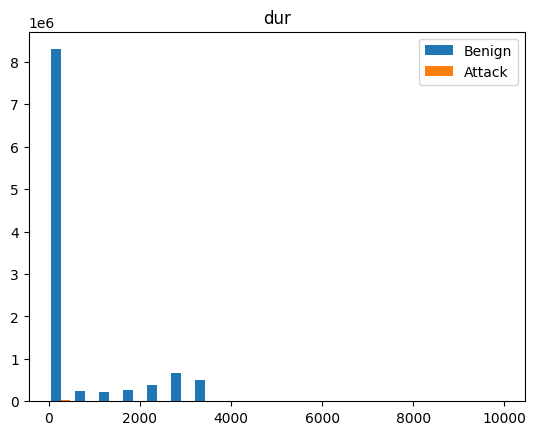

In [19]:
# Histogram penyebaran data benign dan Attack pada dur.
x = BenignData["dur"]
y = AttackData["dur"]
bins = np.linspace(0, 10000, 20) # Berbeda karena mayoritas data bernilai 0 sampai 100, jika menggunakan min max, visualisasi tidak maksimal, dilihat dengan menggunakan DM.describe)

plt.title("dur")
plt.hist([x,y], bins, label=['Benign', 'Attack'])
plt.legend(loc='upper right')
plt.show()

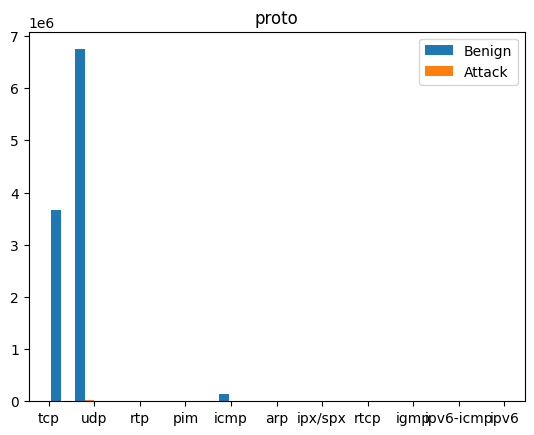

In [22]:
# Histogram penyebaran data benign dan Attack pada proto.
x = BenignData["proto"]
y = AttackData["proto"]
bins = np.linspace(0, 10, 20) # Berbeda karena mayoritas data bernilai 0 sampai 100, jika menggunakan min max, visualisasi tidak maksimal, dilihat dengan menggunakan DM.describe)

plt.title("proto")
plt.hist([x,y], bins, label=['Benign', 'Attack'])
plt.legend(loc='upper right')
plt.show()

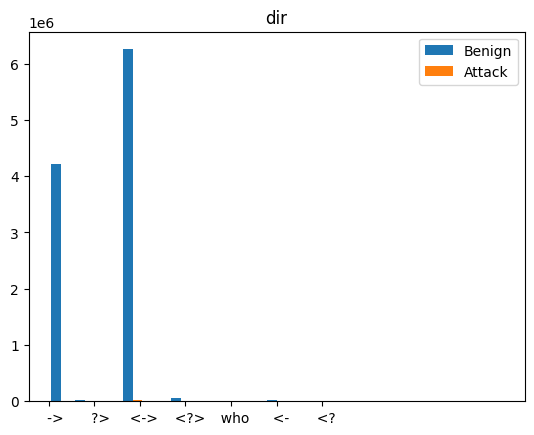

In [24]:
# Histogram penyebaran data benign dan Attack pada dir.
x = BenignData["dir"]
y = AttackData["dir"]
bins = np.linspace(0, 10, 20) # Berbeda karena mayoritas data bernilai 0 sampai 100, jika menggunakan min max, visualisasi tidak maksimal, dilihat dengan menggunakan DM.describe)

plt.title("dir")
plt.hist([x,y], bins, label=['Benign', 'Attack'])
plt.legend(loc='upper right')
plt.show()

TypeError: 'value' must be an instance of str or bytes, not a float

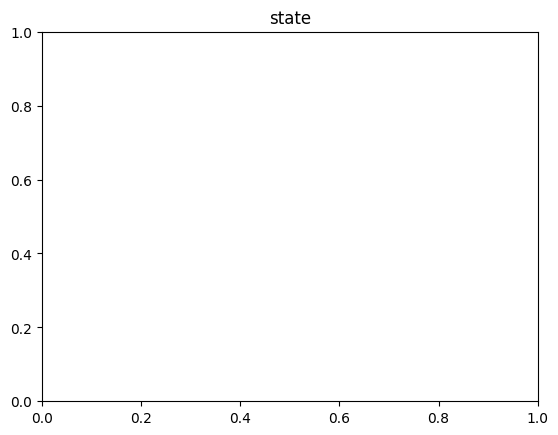

In [25]:
# Histogram penyebaran data benign dan Attack pada state.
x = BenignData["state"]
y = AttackData["state"]
bins = np.linspace(0, 100, 20) # Berbeda karena mayoritas data bernilai 0 sampai 100, jika menggunakan min max, visualisasi tidak maksimal, dilihat dengan menggunakan DM.describe)

plt.title("state")
plt.hist([x,y], bins, label=['Benign', 'Attack'])
plt.legend(loc='upper right')
plt.show()

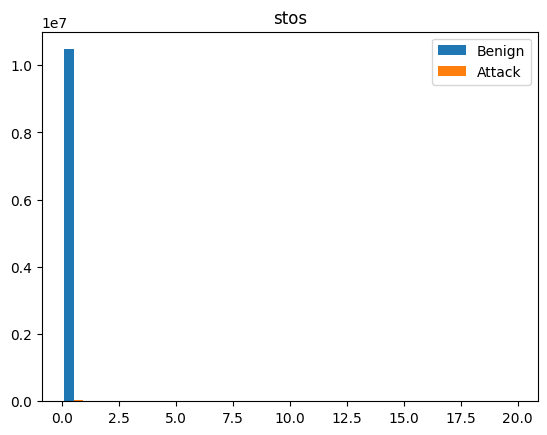

In [27]:
# Histogram penyebaran data benign dan Attack pada stos.
x = BenignData["stos"]
y = AttackData["stos"]
bins = np.linspace(0, 20, 20) # Berbeda karena mayoritas data bernilai 0 sampai 100, jika menggunakan min max, visualisasi tidak maksimal, dilihat dengan menggunakan DM.describe)

plt.title("stos")
plt.hist([x,y], bins, label=['Benign', 'Attack'])
plt.legend(loc='upper right')
plt.show()

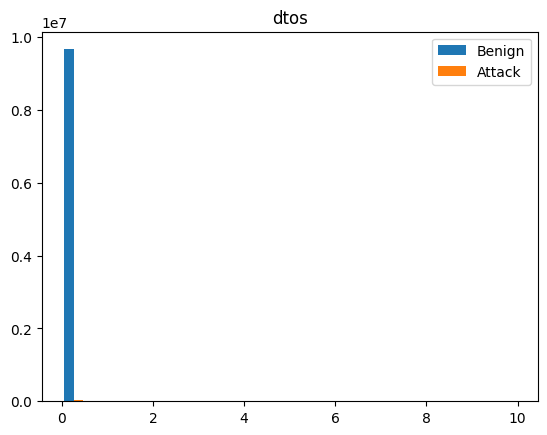

In [28]:
# Histogram penyebaran data benign dan Attack pada dtos.
x = BenignData["dtos"]
y = AttackData["dtos"]
bins = np.linspace(0, 10, 20) # Berbeda karena mayoritas data bernilai 0 sampai 100, jika menggunakan min max, visualisasi tidak maksimal, dilihat dengan menggunakan DM.describe)

plt.title("dtos")
plt.hist([x,y], bins, label=['Benign', 'Attack'])
plt.legend(loc='upper right')
plt.show()

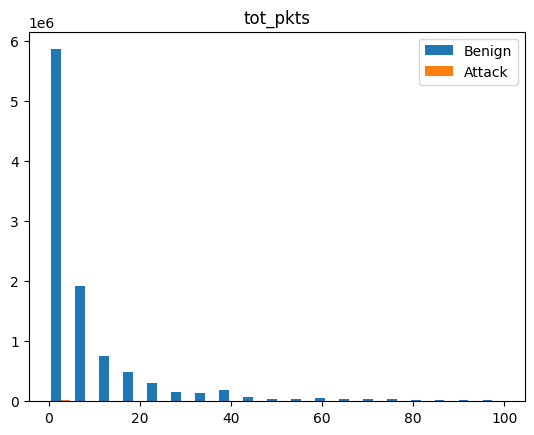

In [29]:
# Histogram penyebaran data benign dan Attack pada dtos.
x = BenignData["tot_pkts"]
y = AttackData["tot_pkts"]
bins = np.linspace(0, 100, 20) # Berbeda karena mayoritas data bernilai 0 sampai 100, jika menggunakan min max, visualisasi tidak maksimal, dilihat dengan menggunakan DM.describe)

plt.title("tot_pkts")
plt.hist([x,y], bins, label=['Benign', 'Attack'])
plt.legend(loc='upper right')
plt.show()

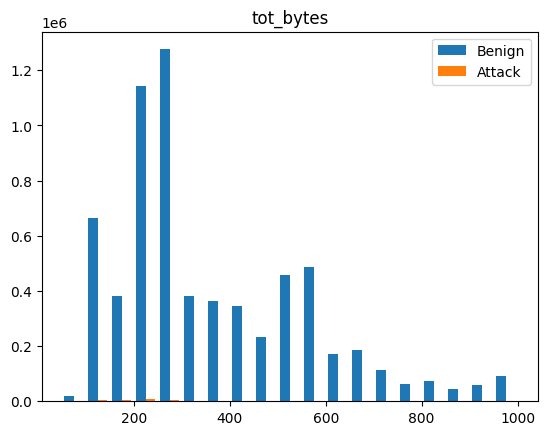

In [31]:
# Histogram penyebaran data benign dan Attack pada tot_bytes.
x = BenignData["tot_bytes"]
y = AttackData["tot_bytes"]
bins = np.linspace(50, 1000, 20) # Berbeda karena mayoritas data bernilai 50 sampai 1000, jika menggunakan min max, visualisasi tidak maksimal, dilihat dengan menggunakan DM.describe)

plt.title("tot_bytes")
plt.hist([x,y], bins, label=['Benign', 'Attack'])
plt.legend(loc='upper right')
plt.show()

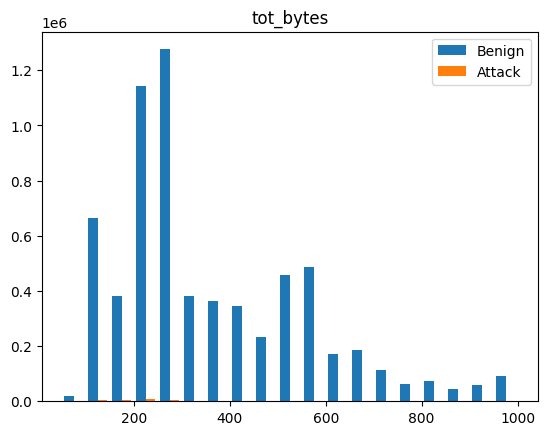

In [31]:
# Histogram penyebaran data benign dan Attack pada tot_bytes.
x = BenignData["tot_bytes"]
y = AttackData["tot_bytes"]
bins = np.linspace(50, 1000, 20) # Berbeda karena mayoritas data bernilai 50 sampai 1000, jika menggunakan min max, visualisasi tidak maksimal, dilihat dengan menggunakan DM.describe)

plt.title("tot_bytes")
plt.hist([x,y], bins, label=['Benign', 'Attack'])
plt.legend(loc='upper right')
plt.show()

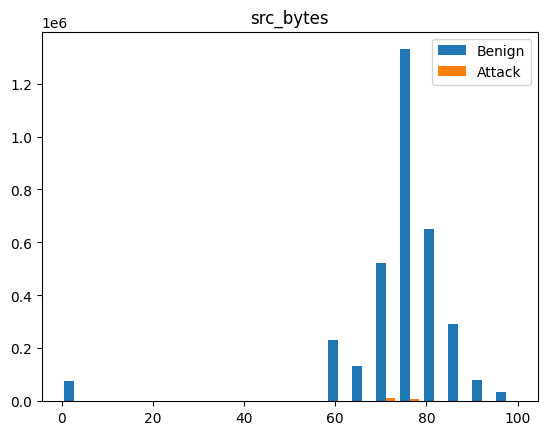

In [32]:
# Histogram penyebaran data benign dan Attack pada src_bytes.
x = BenignData["src_bytes"]
y = AttackData["src_bytes"]
bins = np.linspace(0, 100, 20) # Berbeda karena mayoritas data bernilai 0 sampai 100, jika menggunakan min max, visualisasi tidak maksimal, dilihat dengan menggunakan DM.describe)

plt.title("src_bytes")
plt.hist([x,y], bins, label=['Benign', 'Attack'])
plt.legend(loc='upper right')
plt.show()

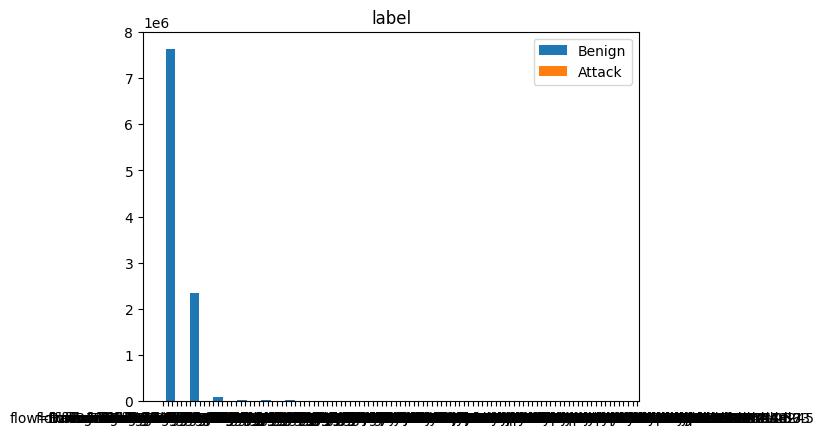

In [33]:
# Histogram penyebaran data benign dan Attack pada label.
x = BenignData["label"]
y = AttackData["label"]
bins = np.linspace(0, 100, 20) # Berbeda karena mayoritas data bernilai 0 sampai 100, jika menggunakan min max, visualisasi tidak maksimal, dilihat dengan menggunakan DM.describe)

plt.title("label")
plt.hist([x,y], bins, label=['Benign', 'Attack'])
plt.legend(loc='upper right')
plt.show()

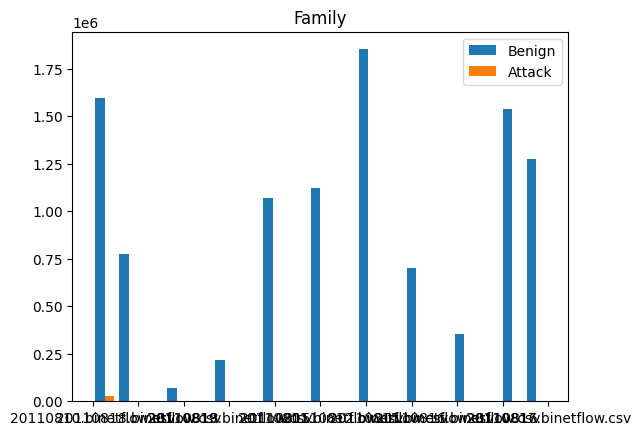

In [36]:
# Histogram penyebaran data benign dan Attack pada Family.
x = BenignData["Family"]
y = AttackData["Family"]
bins = np.linspace(0, 10, 20) # Berbeda karena mayoritas data bernilai 0 sampai 10, jika menggunakan min max, visualisasi tidak maksimal, dilihat dengan menggunakan DM.describe)

plt.title("Family")
plt.hist([x,y], bins, label=['Benign', 'Attack'])
plt.legend(loc='upper right')
plt.show()

In [38]:
# Memilih dan menentukan feature yang berpotensi untuk threshold (Penyebarannya sangat terlihat dan 2 class dapat dipisahkan dengan mudah)
Dataset = DM[[]] # mendrop yang penyebarannya sangat kecil atau tidak dapat membendakan 2 class
Target = DM['binary_label'].values # CLass karena merepresentasikan binary class

In [39]:
# Memilih 100% data secara acak dari setiap fitur/column
sampled_data = DM.groupby('label', group_keys=False).apply(lambda x: x.sample(frac=1)).reset_index(drop=True)
hasil_threshold = []

C:\Users\Muhammad Raihan\AppData\Local\Temp\ipykernel_17312\558593784.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_data = DM.groupby('label', group_keys=False).apply(lambda x: x.sample(frac=1)).reset_index(drop=True)


In [41]:
# Menampilkan list feature yang digunakan
Feature = sampled_data[[]].columns.tolist()
print("         List Features yang akan dibandingkan kinerja-nya           ")
print("                                                                    ")
print("#   Column                                  Non-Null Count  Dtype   ")
print("---  ------                                  --------------  -----  ")

features = []
for i, column_name in enumerate(Feature):
    print(f"{i+1:3} {column_name:40} {sampled_data[column_name].count():<15} {sampled_data[column_name].dtype}")
    features.append(column_name)

         List Features yang akan dibandingkan kinerja-nya           
                                                                    
#   Column                                  Non-Null Count  Dtype   
---  ------                                  --------------  -----  


In [42]:
def Thresholding(threshold, feature):
    # Mengukur waktu mulai
    start_time = time.time()

    # Melakukan thresholding
    BenignDataThreshold = sampled_data[sampled_data[feature] > int(threshold)]
    AttackDataThreshold = sampled_data[sampled_data[feature] <= int(threshold)]

    # Untuk BenignDataThreshold
    y_true_benign = [0] * len(BenignDataThreshold)
    y_pred_benign = BenignDataThreshold["binary_label"]

    # Untuk AttackDataThreshold
    y_true_Attack = [1] * len(AttackDataThreshold)
    y_pred_Attack = AttackDataThreshold["binary_label"]

    # Menyatukan true labels dan predicted labels
    y_true = y_true_benign + y_true_Attack
    y_pred = y_pred_benign.tolist() + y_pred_Attack.tolist()

    # Menghitung confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Menghitung Precision, Recall, F1-score, dan Accuracy
    PrecisionThreshold = tp / (tp + fp) if (tp + fp) != 0 else 0
    RecallThreshold = tp / (tp + fn) if (tp + fn) != 0 else 0
    F1ScoreThreshold = 2 * ((PrecisionThreshold * RecallThreshold) / (PrecisionThreshold + RecallThreshold)) if (PrecisionThreshold + RecallThreshold) != 0 else 0
    AccuracyThreshold = (tp + tn) / (tp + fp + tn + fn) if (tp + fp + tn + fn) != 0 else 0

    # Mengukur waktu selesai
    elapsed_time = time.time() - start_time

    # Menyimpan hasil dalam format satu baris untuk setiap threshold
    hasil_threshold.append([feature, threshold, PrecisionThreshold, RecallThreshold, F1ScoreThreshold, AccuracyThreshold, elapsed_time])

# Lakukan thresholding pada fitur yang dipilih oleh Chi-Square Test
for feature in tqdm(features, desc='Progress'):
    # Pastikan bahwa Min dan Max adalah nilai numerik
    Max = pd.to_numeric(sampled_data[feature], errors='coerce').max()
    Min = pd.to_numeric(sampled_data[feature], errors='coerce').min()

    # Cek apakah Min dan Max valid (bukan NaN)
    if pd.notna(Min) and pd.notna(Max):
        for x in range(int(Min), int(Max + 1)):
            Thresholding(x, feature)
    else:
        print(f"Fitur {feature} mengandung nilai non-numerik dan tidak dapat diproses.")

print(hasil_threshold)

# Mengubah hasil menjadi DataFrame dengan kolom yang sesuai
hasil_threshold_df = pd.DataFrame(hasil_threshold, columns=['Feature', 'Threshold', 'Precision', 'Recall', 'F1_Score', 'Accuracy', 'Elapsed_Time'])

# Simpan DataFrame ke CSV
hasil_threshold_df.to_csv('Manual Feature Selection.csv', index=False)

print("Hasil threshold disimpan ke dalam file 'Manual Feature Selection.csv'")

Progress: 0it [00:00, ?it/s]

[]
Hasil threshold disimpan ke dalam file 'Manual Feature Selection.csv'


In [43]:
HasilThreshold = pd.read_csv("C:\\Data Raihan\\Penelitian Threshold\\05-10-2024\\Manual Feature Selection.csv")
HasilThreshold.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 0 entries
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Feature       0 non-null      object
 1   Threshold     0 non-null      object
 2   Precision     0 non-null      object
 3   Recall        0 non-null      object
 4   F1_Score      0 non-null      object
 5   Accuracy      0 non-null      object
 6   Elapsed_Time  0 non-null      object
dtypes: object(7)
memory usage: 132.0+ bytes


In [44]:
# Inisialisasi variabel winner untuk masing-masing metrik
winner_precision = ['', '', 0]  # [feature, threshold, value]
winner_recall = ['', '', 0]
winner_f1_score = ['', '', 0]
winner_accuracy = ['', '', 0]
winner_run_time = ['', '', float('inf')]  # Memilih yang terendah, jadi diinisialisasi dengan tak hingga

# Iterasi melalui setiap baris di HasilThreshold
for index, result in HasilThreshold.iterrows():
    # result['Feature'], result['Threshold'], result['Precision'], 
    # result['Recall'], result['F1_Score'], result['Accuracy'],
    # result['Elapsed_Time']
    
    # Membandingkan Precision
    if result['Precision'] > winner_precision[2]:  # result['Precision']
        winner_precision = [result['Feature'], result['Threshold'], result['Precision']]  # [feature, threshold, Precision]
    
    # Membandingkan Recall
    if result['Recall'] > winner_recall[2]:  # result['Recall']
        winner_recall = [result['Feature'], result['Threshold'], result['Recall']]  # [feature, threshold, Recall]

    # Membandingkan F1-score
    if result['F1_Score'] > winner_f1_score[2]:  # result['F1_Score']
        winner_f1_score = [result['Feature'], result['Threshold'], result['F1_Score']]  # [feature, threshold, F1 Score]

    # Membandingkan Accuracy
    if result['Accuracy'] > winner_accuracy[2]:  # result['Accuracy']
        winner_accuracy = [result['Feature'], result['Threshold'], result['Accuracy']]  # [feature, threshold, Accuracy]

    # Membandingkan waktu running (run_time) untuk threshold tercepat (terkecil)
    if result['Elapsed_Time'] < winner_run_time[2]:  # result['Elapsed_Time']
        winner_run_time = [result['Feature'], result['Threshold'], result['Elapsed_Time']]  # [feature, threshold, elapsed_time]

In [45]:
def plot_metrics_for_winner(winner, metric_name):
    winner_feature, winner_threshold = winner[0], winner[1]

    # Memfilter hasil threshold untuk fitur pemenang
    winner_results = HasilThreshold[HasilThreshold['Feature'] == winner_feature]

    # Pisahkan hasil menjadi list berdasarkan threshold dan kolom metrik
    thresholds = winner_results['Threshold'].tolist()  # Threshold
    precision = winner_results['Precision'].tolist()   # Precision
    recall = winner_results['Recall'].tolist()         # Recall
    f1_score = winner_results['F1_Score'].tolist()     # F1 Score
    accuracy = winner_results['Accuracy'].tolist()      # Accuracy

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, accuracy, label='Accuracy', marker='o')
    plt.plot(thresholds, precision, label='Precision', marker='o')
    plt.plot(thresholds, recall, label='Recall', marker='o')
    plt.plot(thresholds, f1_score, label='F1 Score', marker='o')

    plt.title(f'{metric_name} Winner: Metrics vs. Threshold for Feature {winner_feature}')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)
    plt.show()

In [46]:
def plot_runtime_for_winner(winner):
    winner_feature, winner_threshold = winner[0], winner[1]

    # Memfilter hasil threshold untuk fitur pemenang
    winner_results = HasilThreshold[HasilThreshold['Feature'] == winner_feature]

    # Pisahkan hasil menjadi list berdasarkan threshold dan run_time
    thresholds = winner_results['Threshold'].tolist()    # Threshold
    run_time = winner_results['Elapsed_Time'].tolist()   # Run Time (elapsed_time)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, run_time, label='Run Time', marker='o')

    plt.title(f'Run Time Winner: Run Time vs. Threshold for Feature {winner_feature}')
    plt.xlabel('Threshold')
    plt.ylabel('Run Time (seconds)')
    plt.legend()
    plt.grid(True)
    plt.show()

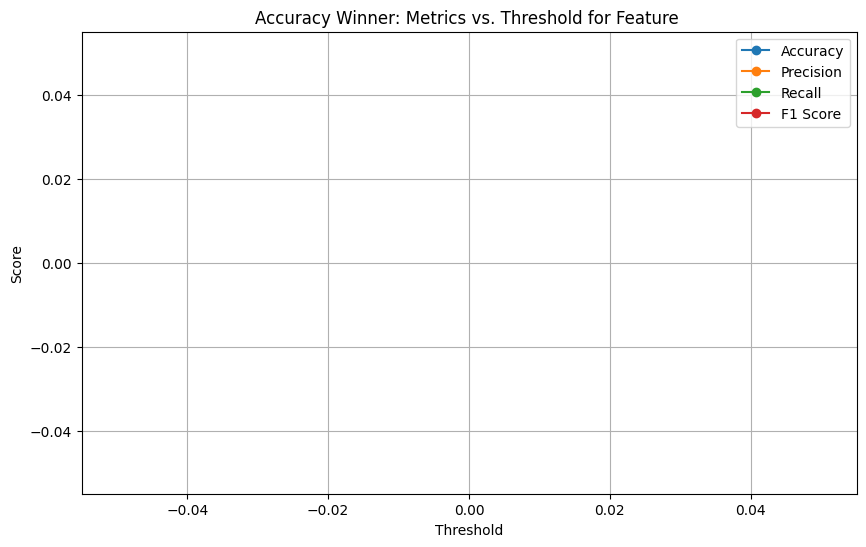

In [47]:
# Plot untuk Accuracy Winner
plot_metrics_for_winner(winner_accuracy, 'Accuracy')

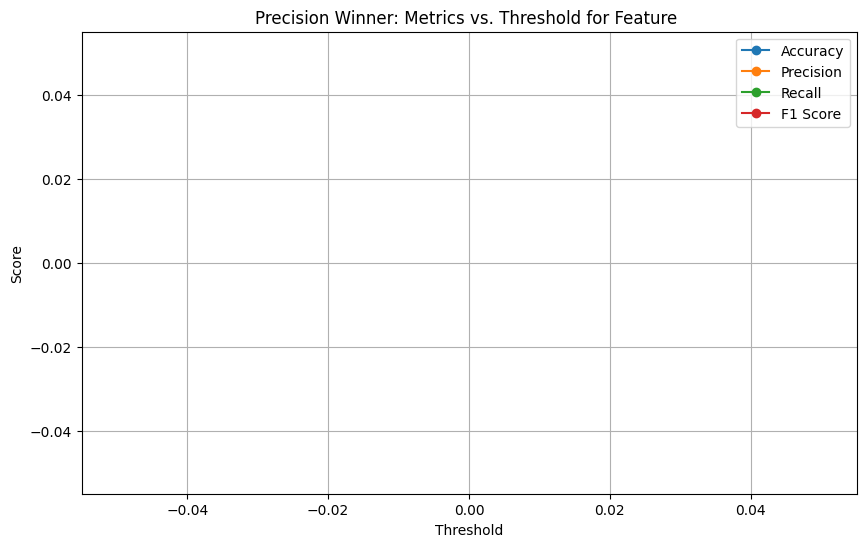

In [48]:
# Plot untuk Precision Winner
plot_metrics_for_winner(winner_precision, 'Precision')

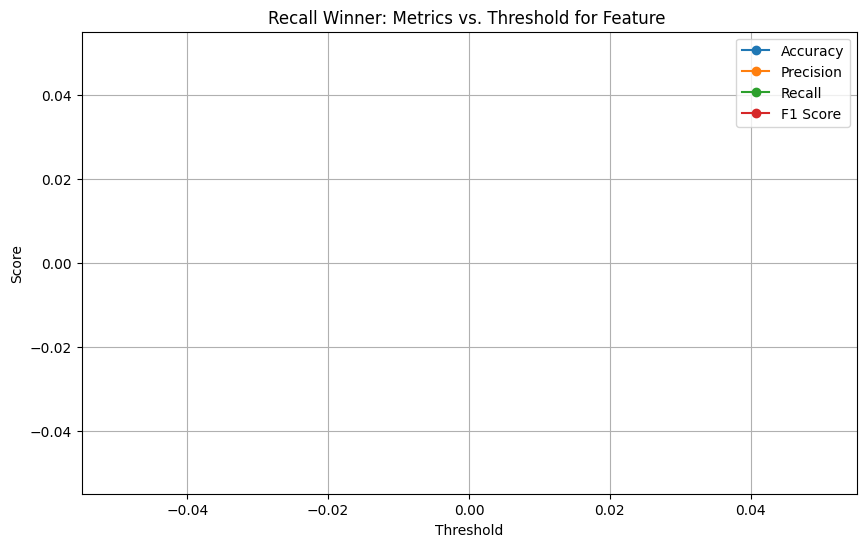

In [49]:
# Plot untuk Recall Winner
plot_metrics_for_winner(winner_recall, 'Recall')

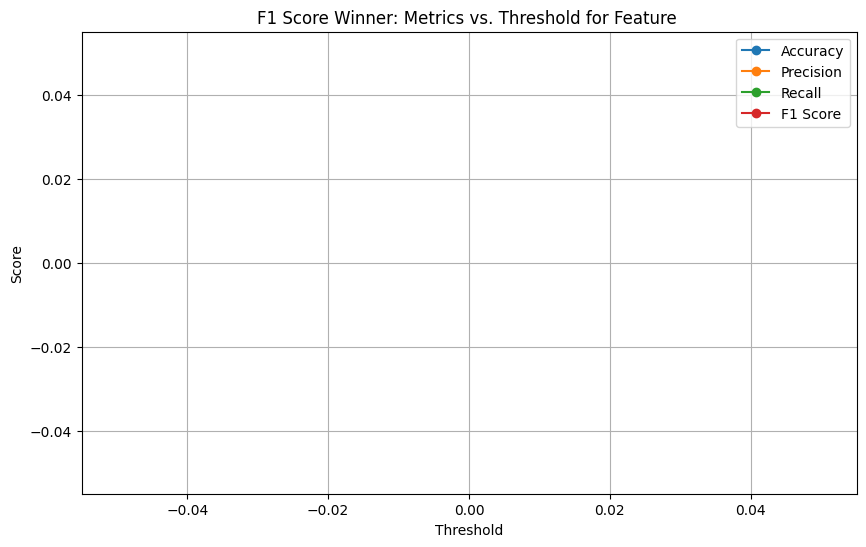

In [50]:
# Plot untuk F1-Score Winner
plot_metrics_for_winner(winner_f1_score, 'F1 Score')

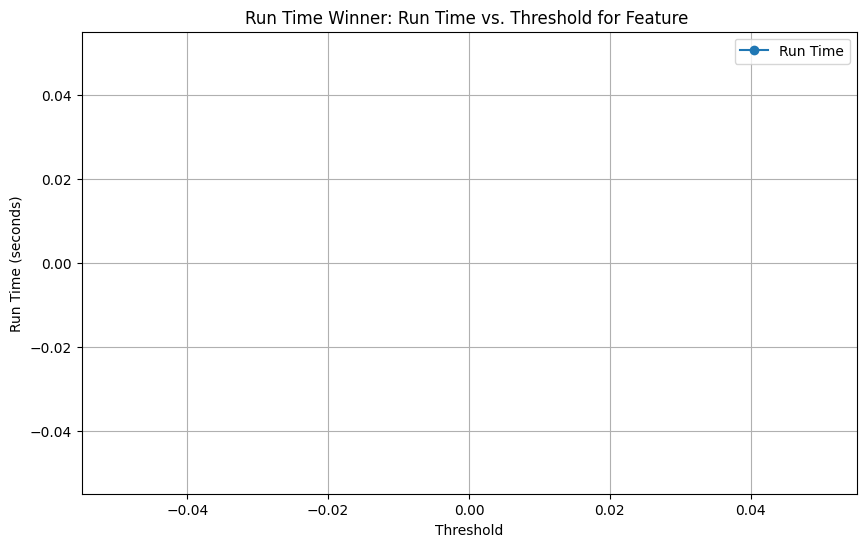

In [51]:
# Plot untuk Run Time Winner
plot_runtime_for_winner(winner_run_time)

In [52]:
# Output untuk setiap metrik
print(f"Precision terbaik dicapai dengan fitur {winner_precision[0]} dan threshold {winner_precision[1]}, menghasilkan precision {winner_precision[2]}.")
print(f"Recall terbaik dicapai dengan fitur {winner_recall[0]} dan threshold {winner_recall[1]}, menghasilkan recall {winner_recall[2]}.")
print(f"F1-score terbaik dicapai dengan fitur {winner_f1_score[0]} dan threshold {winner_f1_score[1]}, menghasilkan F1-score {winner_f1_score[2]}.")
print(f"Akurasi terbaik dicapai dengan fitur {winner_accuracy[0]} dan threshold {winner_accuracy[1]}, menghasilkan akurasi {winner_accuracy[2]}.")
print(f"Waktu running tercepat dicapai dengan fitur {winner_run_time[0]} dan threshold {winner_run_time[1]}, dengan waktu running {winner_run_time[2]} detik.")

Precision terbaik dicapai dengan fitur  dan threshold , menghasilkan precision 0.
Recall terbaik dicapai dengan fitur  dan threshold , menghasilkan recall 0.
F1-score terbaik dicapai dengan fitur  dan threshold , menghasilkan F1-score 0.
Akurasi terbaik dicapai dengan fitur  dan threshold , menghasilkan akurasi 0.
Waktu running tercepat dicapai dengan fitur  dan threshold , dengan waktu running inf detik.
